# Metode Segmentasi GrabCut

GrabCut adalah salah satu metode segmentasi citra yang digunakan untuk memisahkan objek foreground dari background secara semi-otomatis. Metode ini tidak memerlukan proses pelatihan seperti pada model deep learning, tetapi memanfaatkan informasi awal dari pengguna berupa region kasar (misalnya sebuah bounding box yang mengelilingi objek).

Secara garis besar, GrabCut bekerja dengan cara memodelkan piksel foreground dan background menggunakan Gaussian Mixture Model (GMM), kemudian memformulasikan masalah segmentasi sebagai masalah pemotongan graf (graph cut). Pertama, pengguna memberikan inisialisasi berupa kotak yang mengandung objek. Piksel di luar kotak dianggap sebagai background pasti, sedangkan piksel di dalam kotak dianggap masih belum pasti (bisa foreground atau background). Berdasarkan informasi ini, GrabCut membangun model statistik warna untuk foreground dan background, kemudian secara iteratif memperbarui model tersebut dan mengoptimalkan pemisahan piksel dengan meminimalkan suatu fungsi energi. Hasil akhirnya adalah sebuah mask yang menunjukkan piksel mana yang termasuk objek (foreground) dan mana yang termasuk latar belakang (background).

Keunggulan GrabCut adalah kemampuannya menghasilkan segmentasi yang cukup baik hanya dengan input sederhana dari pengguna, tanpa perlu dataset anotasi. Namun, karena sangat bergantung pada perbedaan intensitas dan warna antara foreground dan background, metode ini cenderung melemah ketika objek memiliki warna yang mirip dengan background atau ketika kontras pada citra sangat rendah (misalnya citra gelap di malam hari).

### Cara kerja GrabCut secara ringkas:
1. Pengguna memberikan region awal (rect / mask) yang kira-kira berisi objek.
   Piksel di luar rect dianggap sebagai background pasti, sedangkan piksel di
   dalam rect dianggap masih "unknown" (bisa foreground atau background).
2. Algoritma memodelkan distribusi warna foreground dan background dengan
   Gaussian Mixture Model (GMM).
3. Berdasarkan model tersebut, masalah segmentasi diformulasikan sebagai
   masalah graph cut, yaitu memilih pemisahan piksel yang meminimalkan fungsi
   energi (energy minimization).
4. Proses ini dijalankan secara iteratif: model GMM diperbarui, lalu graph cut
   dihitung ulang sampai diperoleh segmentasi yang stabil.

Output GrabCut adalah sebuah mask yang membedakan piksel foreground dan
background. Metode ini bekerja cukup baik ketika warna/kontras objek dan
background berbeda dengan jelas, tetapi menjadi kurang efektif ketika objek
dan background memiliki warna yang sangat mirip atau citra berada pada kondisi
low contrast (misalnya foto gelap di malam hari).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Gambar Terang

In [9]:
# ==========================
# 1. Baca gambar
# ==========================

# Path / nama file gambar yang akan diproses
img_path = "cerah2.png"
img = cv2.imread(img_path)

# Jika gambar gagal dibaca (misal path salah), hentikan program dengan error
if img is None:
    raise FileNotFoundError(
        f"Gambar '{img_path}' tidak ditemukan. Pastikan path dan namanya benar."
    )

# (Opsional) Resize gambar jika terlalu besar / ingin ukuran tetap
# scale = 0.7 berarti 70% dari ukuran asli
scale = 1.0
img = cv2.resize(img, None, fx=scale, fy=scale)

# Tampilkan informasi ukuran gambar setelah di-resize
# img.shape = (height, width, channels), jadi:
# - img.shape[1] = width
# - img.shape[0] = height
print(f"Ukuran gambar setelah resize: {img.shape[1]} x {img.shape[0]} (width x height)")

# Simpan salinan gambar asli (hasil resize) untuk referensi jika dibutuhkan
img_original = img.copy()

Ukuran gambar setelah resize: 3000 x 4000 (width x height)



Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 100
  y = 1500
  w = 2700
  h = 1000


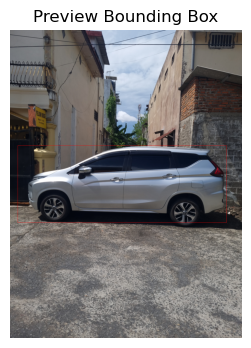

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 200
  y = 1480
  w = 1550
  h = 1100


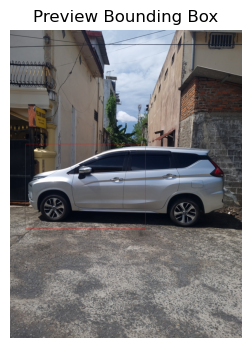

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 180
  y = 1450
  w = 2650
  h = 1100


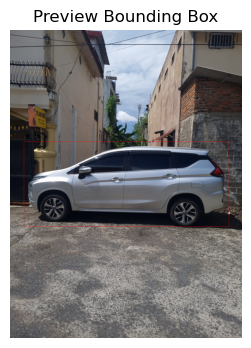

Bounding box dikonfirmasi. Lanjut ke GrabCut...



In [10]:
# ==========================
# 2. Loop input bounding box + preview
# ==========================

# Loop ini akan terus berjalan sampai pengguna menyatakan
# bahwa bounding box yang dimasukkan sudah OK (jawab 'y')
while True:
    print("\nMasukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):")
    print("Note: (x, y) = titik kiri-atas kotak")

    # Input posisi kiri-atas bounding box (koordinat x dan y)
    # x = jarak dari sisi kiri gambar (dalam piksel)
    # y = jarak dari sisi atas gambar (dalam piksel)
    x = int(input("x (kiri): "))
    y = int(input("y (atas): "))

    # Input ukuran bounding box:
    # w = lebar kotak (arah horizontal, dalam piksel)
    # h = tinggi kotak (arah vertikal, dalam piksel)
    w = int(input("w (lebar kotak): "))
    h = int(input("h (tinggi kotak): "))

    # Tampilkan kembali nilai bounding box yang baru saja dimasukkan
    # supaya pengguna bisa mengecek di terminal
    print("\nBounding box yang kamu input:")
    print(f"  x = {x}")
    print(f"  y = {y}")
    print(f"  w = {w}")
    print(f"  h = {h}")

    # Simpan bounding box dalam format tuple (x, y, w, h)
    # Format ini yang dipakai oleh fungsi cv2.grabCut
    rect = (x, y, w, h)

    # Copy gambar asli agar bisa digambar bounding box di atasnya
    # tanpa mengubah variabel img asli
    img_bb = img.copy()

    # Gambar bounding box di atas gambar:
    # - Titik kiri-atas  : (x, y)
    # - Titik kanan-bawah: (x + w, y + h)
    # - Warna garis      : (0, 0, 255) = merah (format BGR)
    # - Ketebalan garis  : 2 piksel
    cv2.rectangle(img_bb, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # OpenCV menyimpan gambar dalam format BGR,
    # sedangkan matplotlib mengharapkan RGB,
    # jadi perlu dikonversi dulu sebelum ditampilkan.
    img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar dengan bounding box untuk preview
    plt.figure(figsize=(6, 4))
    plt.title("Preview Bounding Box")
    plt.imshow(img_bb_rgb)
    plt.axis("off")  # Hilangkan axis supaya tampilan lebih bersih
    plt.show()

    # Setelah melihat preview, pengguna diminta konfirmasi:
    # - ketik 'y' jika bounding box sudah sesuai
    # - ketik 'n' jika ingin mengulang input
    ans = input("Apakah bounding box sudah OK? (y/n): ").strip().lower()

    if ans == 'y':
        # Jika sudah OK, keluar dari loop dan lanjut ke tahap GrabCut
        print("Bounding box dikonfirmasi. Lanjut ke GrabCut...\n")
        break
    else:
        # Jika belum OK, ulangi proses input bounding box
        print("Proses input bounding box diulang.\n")

In [11]:
# ==========================
# 3. Jalankan GrabCut dengan bounding box yang sudah OK
# ==========================

# Siapkan mask dan model background/foreground untuk GrabCut.
# - mask    : menyimpan label setiap piksel (background / foreground / probable)
# - bgModel : model internal untuk background (dipakai GrabCut)
# - fgModel : model internal untuk foreground (dipakai GrabCut)
mask = np.zeros(img.shape[:2], np.uint8)             # ukuran [H, W]
bgModel = np.zeros((1, 65), np.float64)              # model background internal
fgModel = np.zeros((1, 65), np.float64)              # model foreground internal

# Jumlah iterasi GrabCut:
# - Semakin besar iterasi, umumnya hasil segmentasi lebih bagus,
#   tapi waktu komputasi juga lebih lama.
iterasi = 15  

# Panggil fungsi GrabCut:
# - img      : gambar input (BGR)
# - mask     : mask yang akan diisi oleh GrabCut
# - rect     : bounding box (x, y, w, h)
# - bgModel  : model background (akan dimodifikasi oleh GrabCut)
# - fgModel  : model foreground (akan dimodifikasi oleh GrabCut)
# - iterasi  : jumlah iterasi
# - mode     : GC_INIT_WITH_RECT artinya inisialisasi pakai bounding box
cv2.grabCut(img, mask, rect, bgModel, fgModel, iterasi, cv2.GC_INIT_WITH_RECT)

# Konversi mask GrabCut ke mask biner:
# GrabCut bisa memberi label:
# - 0 = cv2.GC_BGD     : background pasti
# - 1 = cv2.GC_FGD     : foreground pasti
# - 2 = cv2.GC_PR_BGD  : background kemungkinan
# - 3 = cv2.GC_PR_FGD  : foreground kemungkinan
#
# Di sini, kita gabungkan:
# - label 0 dan 2 -> 0 (background)
# - label 1 dan 3 -> 1 (foreground)
mask_bin = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')

# Aplikasikan mask biner ke gambar:
# - mask_bin : [H, W]
# - untuk dikalikan dengan img [H, W, 3], kita perlu menambahkan axis baru di belakang
#   sehingga menjadi [H, W, 1] lalu broadcasting ke 3 channel.
segmented = img * mask_bin[:, :, np.newaxis]

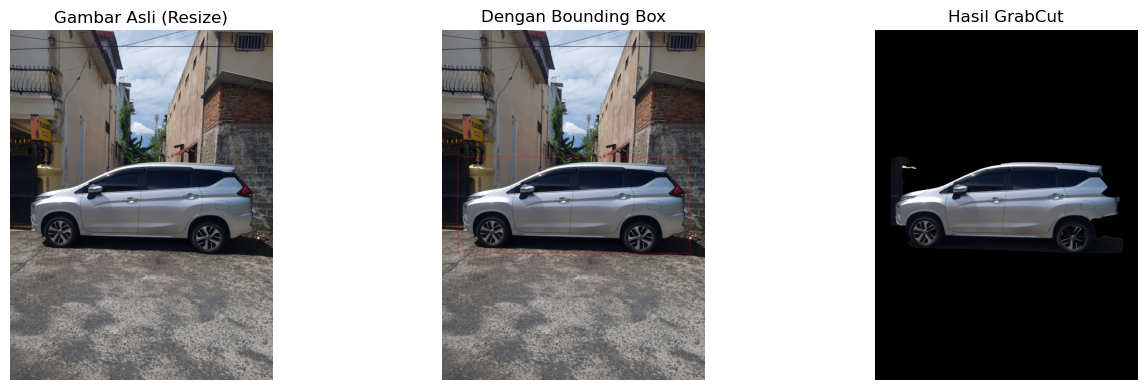

Selesai.


In [12]:
# ==========================
# 4. Konversi ke RGB & tampilkan hasil
# ==========================

# Konversi gambar BGR ke RGB untuk ditampilkan dengan matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Tampilkan:
# - Gambar asli (setelah resize)
# - Gambar dengan bounding box
# - Hasil segmentasi GrabCut
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("Gambar Asli (Resize)")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Dengan Bounding Box")
plt.imshow(img_bb_rgb)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Hasil GrabCut")
plt.imshow(segmented_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

print("Selesai.")

## 2. Gambar Remang

In [13]:
# ==========================
# 1. Baca gambar
# ==========================

# Path / nama file gambar yang akan diproses
img_path = "remang1.png"
img = cv2.imread(img_path)

# Jika gambar gagal dibaca (misal path salah), hentikan program dengan error
if img is None:
    raise FileNotFoundError(
        f"Gambar '{img_path}' tidak ditemukan. Pastikan path dan namanya benar."
    )

# (Opsional) Resize gambar jika terlalu besar / ingin ukuran tetap
# scale = 0.7 berarti 70% dari ukuran asli
scale = 1.0
img = cv2.resize(img, None, fx=scale, fy=scale)

# Tampilkan informasi ukuran gambar setelah di-resize
# img.shape = (height, width, channels), jadi:
# - img.shape[1] = width
# - img.shape[0] = height
print(f"Ukuran gambar setelah resize: {img.shape[1]} x {img.shape[0]} (width x height)")

# Simpan salinan gambar asli (hasil resize) untuk referensi jika dibutuhkan
img_original = img.copy()

Ukuran gambar setelah resize: 3000 x 4000 (width x height)



Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 200
  y = 1000
  w = 2800
  h = 1200


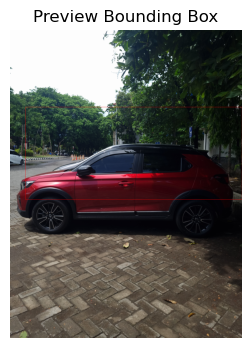

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 100
  y = 1300
  w = 1500
  h = 1300


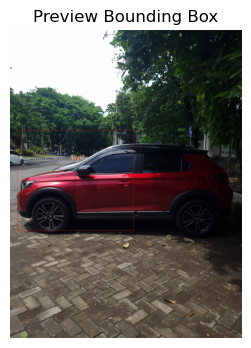

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 100
  y = 1400
  w = 2500
  h = 1350


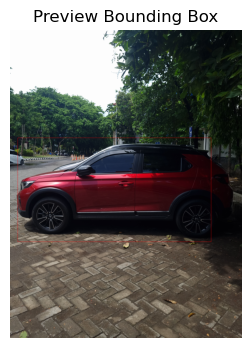

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 80
  y = 1400
  w = 2650
  h = 1350


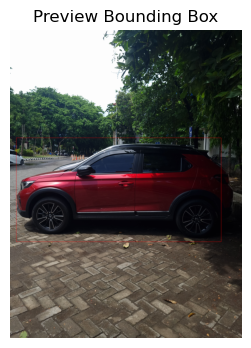

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 80
  y = 1400
  w = 2700
  h = 1350


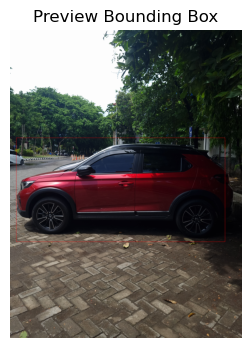

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 80
  y = 1400
  w = 2730
  h = 1350


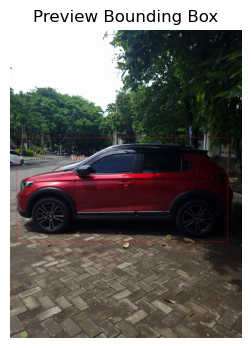

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 80
  y = 1400
  w = 2770
  h = 1350


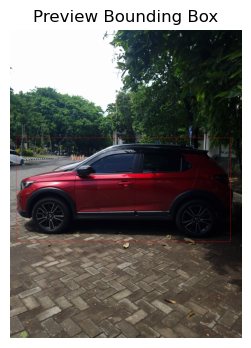

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 80
  y = 1400
  w = 2800
  h = 1350


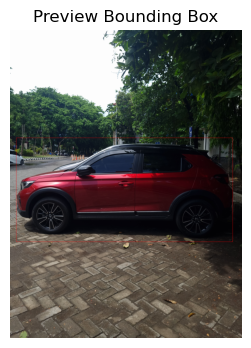

Bounding box dikonfirmasi. Lanjut ke GrabCut...



In [14]:
# ==========================
# 2. Loop input bounding box + preview
# ==========================

# Loop ini akan terus berjalan sampai pengguna menyatakan
# bahwa bounding box yang dimasukkan sudah OK (jawab 'y')
while True:
    print("\nMasukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):")
    print("Note: (x, y) = titik kiri-atas kotak")

    # Input posisi kiri-atas bounding box (koordinat x dan y)
    # x = jarak dari sisi kiri gambar (dalam piksel)
    # y = jarak dari sisi atas gambar (dalam piksel)
    x = int(input("x (kiri): "))
    y = int(input("y (atas): "))

    # Input ukuran bounding box:
    # w = lebar kotak (arah horizontal, dalam piksel)
    # h = tinggi kotak (arah vertikal, dalam piksel)
    w = int(input("w (lebar kotak): "))
    h = int(input("h (tinggi kotak): "))

    # Tampilkan kembali nilai bounding box yang baru saja dimasukkan
    # supaya pengguna bisa mengecek di terminal
    print("\nBounding box yang kamu input:")
    print(f"  x = {x}")
    print(f"  y = {y}")
    print(f"  w = {w}")
    print(f"  h = {h}")

    # Simpan bounding box dalam format tuple (x, y, w, h)
    # Format ini yang dipakai oleh fungsi cv2.grabCut
    rect = (x, y, w, h)

    # Copy gambar asli agar bisa digambar bounding box di atasnya
    # tanpa mengubah variabel img asli
    img_bb = img.copy()

    # Gambar bounding box di atas gambar:
    # - Titik kiri-atas  : (x, y)
    # - Titik kanan-bawah: (x + w, y + h)
    # - Warna garis      : (0, 0, 255) = merah (format BGR)
    # - Ketebalan garis  : 2 piksel
    cv2.rectangle(img_bb, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # OpenCV menyimpan gambar dalam format BGR,
    # sedangkan matplotlib mengharapkan RGB,
    # jadi perlu dikonversi dulu sebelum ditampilkan.
    img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar dengan bounding box untuk preview
    plt.figure(figsize=(6, 4))
    plt.title("Preview Bounding Box")
    plt.imshow(img_bb_rgb)
    plt.axis("off")  # Hilangkan axis supaya tampilan lebih bersih
    plt.show()

    # Setelah melihat preview, pengguna diminta konfirmasi:
    # - ketik 'y' jika bounding box sudah sesuai
    # - ketik 'n' jika ingin mengulang input
    ans = input("Apakah bounding box sudah OK? (y/n): ").strip().lower()

    if ans == 'y':
        # Jika sudah OK, keluar dari loop dan lanjut ke tahap GrabCut
        print("Bounding box dikonfirmasi. Lanjut ke GrabCut...\n")
        break
    else:
        # Jika belum OK, ulangi proses input bounding box
        print("Proses input bounding box diulang.\n")

In [15]:
# ==========================
# 3. Jalankan GrabCut dengan bounding box yang sudah OK
# ==========================

# Siapkan mask dan model background/foreground untuk GrabCut.
# - mask    : menyimpan label setiap piksel (background / foreground / probable)
# - bgModel : model internal untuk background (dipakai GrabCut)
# - fgModel : model internal untuk foreground (dipakai GrabCut)
mask = np.zeros(img.shape[:2], np.uint8)             # ukuran [H, W]
bgModel = np.zeros((1, 65), np.float64)              # model background internal
fgModel = np.zeros((1, 65), np.float64)              # model foreground internal

# Jumlah iterasi GrabCut:
# - Semakin besar iterasi, umumnya hasil segmentasi lebih bagus,
#   tapi waktu komputasi juga lebih lama.
iterasi = 15  

# Panggil fungsi GrabCut:
# - img      : gambar input (BGR)
# - mask     : mask yang akan diisi oleh GrabCut
# - rect     : bounding box (x, y, w, h)
# - bgModel  : model background (akan dimodifikasi oleh GrabCut)
# - fgModel  : model foreground (akan dimodifikasi oleh GrabCut)
# - iterasi  : jumlah iterasi
# - mode     : GC_INIT_WITH_RECT artinya inisialisasi pakai bounding box
cv2.grabCut(img, mask, rect, bgModel, fgModel, iterasi, cv2.GC_INIT_WITH_RECT)

# Konversi mask GrabCut ke mask biner:
# GrabCut bisa memberi label:
# - 0 = cv2.GC_BGD     : background pasti
# - 1 = cv2.GC_FGD     : foreground pasti
# - 2 = cv2.GC_PR_BGD  : background kemungkinan
# - 3 = cv2.GC_PR_FGD  : foreground kemungkinan
#
# Di sini, kita gabungkan:
# - label 0 dan 2 -> 0 (background)
# - label 1 dan 3 -> 1 (foreground)
mask_bin = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')

# Aplikasikan mask biner ke gambar:
# - mask_bin : [H, W]
# - untuk dikalikan dengan img [H, W, 3], kita perlu menambahkan axis baru di belakang
#   sehingga menjadi [H, W, 1] lalu broadcasting ke 3 channel.
segmented = img * mask_bin[:, :, np.newaxis]

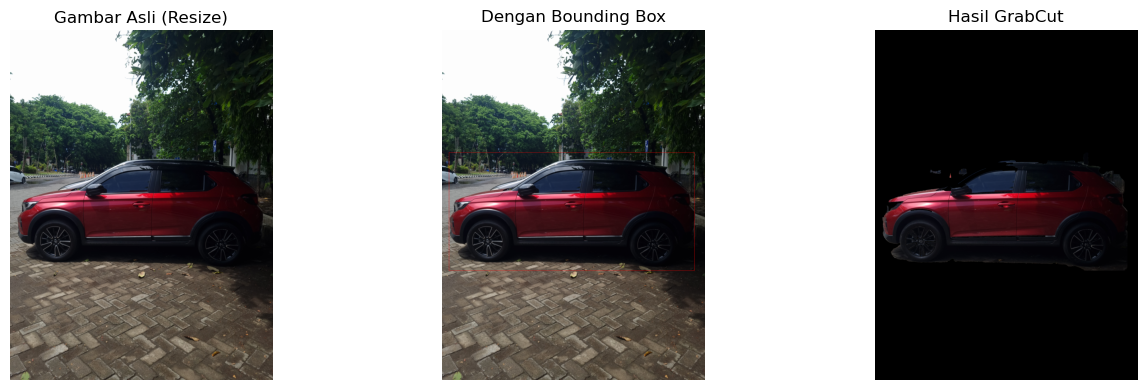

Selesai.


In [16]:
# ==========================
# 4. Konversi ke RGB & tampilkan hasil
# ==========================

# Konversi gambar BGR ke RGB untuk ditampilkan dengan matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Tampilkan:
# - Gambar asli (setelah resize)
# - Gambar dengan bounding box
# - Hasil segmentasi GrabCut
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("Gambar Asli (Resize)")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Dengan Bounding Box")
plt.imshow(img_bb_rgb)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Hasil GrabCut")
plt.imshow(segmented_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

print("Selesai.")

## 3. Gambar Gelap

In [17]:
# ==========================
# 1. Baca gambar
# ==========================

# Path / nama file gambar yang akan diproses
img_path = "gelap2.png"
img = cv2.imread(img_path)

# Jika gambar gagal dibaca (misal path salah), hentikan program dengan error
if img is None:
    raise FileNotFoundError(
        f"Gambar '{img_path}' tidak ditemukan. Pastikan path dan namanya benar."
    )

# (Opsional) Resize gambar jika terlalu besar / ingin ukuran tetap
# scale = 0.7 berarti 70% dari ukuran asli
scale = 1.0
img = cv2.resize(img, None, fx=scale, fy=scale)

# Tampilkan informasi ukuran gambar setelah di-resize
# img.shape = (height, width, channels), jadi:
# - img.shape[1] = width
# - img.shape[0] = height
print(f"Ukuran gambar setelah resize: {img.shape[1]} x {img.shape[0]} (width x height)")

# Simpan salinan gambar asli (hasil resize) untuk referensi jika dibutuhkan
img_original = img.copy()

Ukuran gambar setelah resize: 3000 x 4000 (width x height)



Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 150
  y = 1400
  w = 2500
  h = 1200


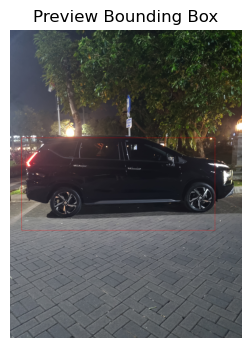

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 150
  y = 1300
  w = 2700
  h = 1150


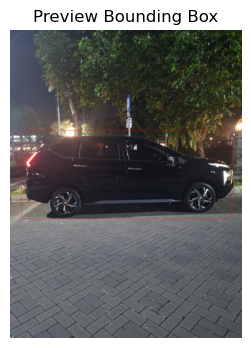

Proses input bounding box diulang.


Masukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):
Note: (x, y) = titik kiri-atas kotak

Bounding box yang kamu input:
  x = 150
  y = 1300
  w = 2750
  h = 1175


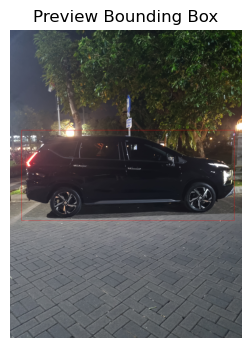

Bounding box dikonfirmasi. Lanjut ke GrabCut...



In [18]:
# ==========================
# 2. Loop input bounding box + preview
# ==========================

# Loop ini akan terus berjalan sampai pengguna menyatakan
# bahwa bounding box yang dimasukkan sudah OK (jawab 'y')
while True:
    print("\nMasukkan koordinat bounding box dalam piksel (berdasarkan gambar yang sudah di-resize):")
    print("Note: (x, y) = titik kiri-atas kotak")

    # Input posisi kiri-atas bounding box (koordinat x dan y)
    # x = jarak dari sisi kiri gambar (dalam piksel)
    # y = jarak dari sisi atas gambar (dalam piksel)
    x = int(input("x (kiri): "))
    y = int(input("y (atas): "))

    # Input ukuran bounding box:
    # w = lebar kotak (arah horizontal, dalam piksel)
    # h = tinggi kotak (arah vertikal, dalam piksel)
    w = int(input("w (lebar kotak): "))
    h = int(input("h (tinggi kotak): "))

    # Tampilkan kembali nilai bounding box yang baru saja dimasukkan
    # supaya pengguna bisa mengecek di terminal
    print("\nBounding box yang kamu input:")
    print(f"  x = {x}")
    print(f"  y = {y}")
    print(f"  w = {w}")
    print(f"  h = {h}")

    # Simpan bounding box dalam format tuple (x, y, w, h)
    # Format ini yang dipakai oleh fungsi cv2.grabCut
    rect = (x, y, w, h)

    # Copy gambar asli agar bisa digambar bounding box di atasnya
    # tanpa mengubah variabel img asli
    img_bb = img.copy()

    # Gambar bounding box di atas gambar:
    # - Titik kiri-atas  : (x, y)
    # - Titik kanan-bawah: (x + w, y + h)
    # - Warna garis      : (0, 0, 255) = merah (format BGR)
    # - Ketebalan garis  : 2 piksel
    cv2.rectangle(img_bb, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # OpenCV menyimpan gambar dalam format BGR,
    # sedangkan matplotlib mengharapkan RGB,
    # jadi perlu dikonversi dulu sebelum ditampilkan.
    img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar dengan bounding box untuk preview
    plt.figure(figsize=(6, 4))
    plt.title("Preview Bounding Box")
    plt.imshow(img_bb_rgb)
    plt.axis("off")  # Hilangkan axis supaya tampilan lebih bersih
    plt.show()

    # Setelah melihat preview, pengguna diminta konfirmasi:
    # - ketik 'y' jika bounding box sudah sesuai
    # - ketik 'n' jika ingin mengulang input
    ans = input("Apakah bounding box sudah OK? (y/n): ").strip().lower()

    if ans == 'y':
        # Jika sudah OK, keluar dari loop dan lanjut ke tahap GrabCut
        print("Bounding box dikonfirmasi. Lanjut ke GrabCut...\n")
        break
    else:
        # Jika belum OK, ulangi proses input bounding box
        print("Proses input bounding box diulang.\n")

In [19]:
# ==========================
# 3. Jalankan GrabCut dengan bounding box yang sudah OK
# ==========================

# Siapkan mask dan model background/foreground untuk GrabCut.
# - mask    : menyimpan label setiap piksel (background / foreground / probable)
# - bgModel : model internal untuk background (dipakai GrabCut)
# - fgModel : model internal untuk foreground (dipakai GrabCut)
mask = np.zeros(img.shape[:2], np.uint8)             # ukuran [H, W]
bgModel = np.zeros((1, 65), np.float64)              # model background internal
fgModel = np.zeros((1, 65), np.float64)              # model foreground internal

# Jumlah iterasi GrabCut:
# - Semakin besar iterasi, umumnya hasil segmentasi lebih bagus,
#   tapi waktu komputasi juga lebih lama.
iterasi = 15  

# Panggil fungsi GrabCut:
# - img      : gambar input (BGR)
# - mask     : mask yang akan diisi oleh GrabCut
# - rect     : bounding box (x, y, w, h)
# - bgModel  : model background (akan dimodifikasi oleh GrabCut)
# - fgModel  : model foreground (akan dimodifikasi oleh GrabCut)
# - iterasi  : jumlah iterasi
# - mode     : GC_INIT_WITH_RECT artinya inisialisasi pakai bounding box
cv2.grabCut(img, mask, rect, bgModel, fgModel, iterasi, cv2.GC_INIT_WITH_RECT)

# Konversi mask GrabCut ke mask biner:
# GrabCut bisa memberi label:
# - 0 = cv2.GC_BGD     : background pasti
# - 1 = cv2.GC_FGD     : foreground pasti
# - 2 = cv2.GC_PR_BGD  : background kemungkinan
# - 3 = cv2.GC_PR_FGD  : foreground kemungkinan
#
# Di sini, kita gabungkan:
# - label 0 dan 2 -> 0 (background)
# - label 1 dan 3 -> 1 (foreground)
mask_bin = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')

# Aplikasikan mask biner ke gambar:
# - mask_bin : [H, W]
# - untuk dikalikan dengan img [H, W, 3], kita perlu menambahkan axis baru di belakang
#   sehingga menjadi [H, W, 1] lalu broadcasting ke 3 channel.
segmented = img * mask_bin[:, :, np.newaxis]

In [ ]:
# ==========================
# 4. Konversi ke RGB & tampilkan hasil
# ==========================

# Konversi gambar BGR ke RGB untuk ditampilkan dengan matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bb_rgb = cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Tampilkan:
# - Gambar asli (setelah resize)
# - Gambar dengan bounding box
# - Hasil segmentasi GrabCut
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("Gambar Asli (Resize)")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Dengan Bounding Box")
plt.imshow(img_bb_rgb)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Hasil GrabCut")
plt.imshow(segmented_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

print("Selesai.")

### Berdasarkan percobaan, metode GrabCut mampu menghasilkan segmentasi yang cukup baik pada citra dengan pencahayaan terang dan perbedaan warna yang jelas antara objek mobil dan latar belakang. Namun, pada citra gelap atau kondisi di mana warna objek sangat mirip dengan background (misalnya mobil hitam di parkiran gelap pada malam hari), kualitas segmentasi menurun secara signifikan.
### Hal ini terjadi karena GrabCut mengandalkan pemodelan perbedaan intensitas dan warna antara foreground dan background. Jika distribusi warna kedua area tersebut terlalu mirip, algoritma kesulitan membedakannya sehingga banyak piksel objek yang ikut terklasifikasi sebagai background (atau sebaliknya). Dengan kata lain, GrabCut kurang robust pada kasus low contrast dan objek yang “blend in” dengan latar belakang, sehingga untuk kondisi tersebut umumnya diperlukan preprocessing tambahan atau pendekatan berbasis deep learning yang lebih kontekstual.